In [1]:
import math
from scipy import interpolate
import gsw
from xmitgcm import open_mdsdataset
import numpy as np
import xarray as xr
import copy
from matplotlib import pyplot as plt
import matplotlib.colors
%matplotlib inline

In [2]:
### for coarse model

rhonil = 999.8
rhoconst = 999.8
tref = 20
sref = 35
sbeta = 7.4e-4
talpha = 2e-4

def get_sigma(temp, lon, lat, lev):
    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    sigma = linear_rho(35, temp, sref, tref) - 1000

    ds_sigma = xr.DataArray(sigma[:, :, :], coords={'Z': lev, 'YC': lat, 'XC': lon},
                            dims=['Z', 'YC', 'XC'])

    return ds_sigma


def linear_rho(s, t, sref, tref):
    rho = 1000 * (sbeta * (s - sref) - talpha * (t - tref)) + 1025
    return rho

def smooth_2d(data):
    m = data.shape[0]
    n = data.shape[1]
    data_new = np.zeros((m, n))
    data_new[:, :] = np.nan
    for i in np.arange(1, m, 1):
        for j in np.arange(1, n, 1):
            tmp = data[i-1:i+2, j-1:j+2]
            if math.isnan(data[i, j]) == False:
                data_new[i, j] = np.nanmean(tmp)
    return data_new

def get_vort_mit(Um_term, Vm_term, dx, dy, raz, num):
    
    vor_term = np.zeros((num, num))
    
    Um_term_dy = np.zeros((num-1, num))
    Vm_term_dx = np.zeros((num, num-1))
    
    um_term_x = Um_term * dx
    vm_term_y = Vm_term * dy
    
    Um_term_dy = (um_term_x[1:, :] - um_term_x[:-1, :]) / raz[1:, :]
    Vm_term_dx = (vm_term_y[:, 1:] - vm_term_y[:, :-1]) / raz[:, 1:]
    
    vor_term[:-1, :-1] = Vm_term_dx[1:, :] - Um_term_dy[:, 1:]

    return vor_term

def smooth_1d(data):
    m = data.shape[0]
    data_new = np.zeros((m, 1))
    data_new[:] = np.nan
    for i in np.arange(1, m, 1):
        tmp = data[i-1:i+2]
        if math.isnan(data[i]) == False:
            data_new[i] = np.nanmean(tmp)
    return data_new

In [3]:
def clim_thermo(sigma, temp, u, v, lon, lat, lev, iso, num):

    m = lon.shape[0]
    n = lat.shape[0]
    l = lev.shape[0]

    z = np.arange(10, 800, 10)

    sigma_z = np.zeros((79, num, num))
    temp_z = np.zeros((79, num, num))
    u_z = np.zeros((79, num, num))
    v_z = np.zeros((79, num, num))

    for k in np.arange(num):
        fun1 = interpolate.interp2d(-lev, lon, sigma[:, k, :].T)
        sigma_z[:, k, :] = fun1(z, lon).T

        fun2 = interpolate.interp2d(-lev, lon, temp[:, k, :].T)
        temp_z[:, k, :] = fun2(z, lon).T

        fun3 = interpolate.interp2d(-lev, lon, u[:, k, :].T)
        u_z[:, k, :] = fun3(z, lon).T

        fun4 = interpolate.interp2d(-lev, lon, v[:, k, :].T)
        v_z[:, k, :] = fun4(z, lon).T

    dep_iso = np.zeros((n, m))
    dep_iso[:, :] = np.nan
    temp_tc = np.zeros((n, m))
    temp_tc[:, :] = np.nan
    u_tc = np.zeros((n, m))
    u_tc[:, :] = np.nan
    v_tc = np.zeros((n, m))
    v_tc[:, :] = np.nan
    nz = np.zeros((n, m))
    
    for i in np.arange(0, m, 1):
        for j in np.arange(0, n, 1):

            den_tmp = sigma_z[:, j, i]
            temp_tmp = temp_z[:, j, i]
            u_tmp = u_z[:, j, i]
            v_tmp = v_z[:, j, i]

            id1 = np.where(den_tmp < iso)

            if np.size(id1) > 0 and np.size(id1) < len(z):

                den1 = den_tmp[id1[0][-1]]
                den2 = den_tmp[id1[0][-1] + 1]

                if den1 < den2:

                    fun = interpolate.interp1d(
                        [den1, den2], [z[id1[0][-1]], z[id1[0][-1] + 1]])
                    dep_iso[j, i] = fun(iso)

                    temp_tc[j, i] = np.nanmean(temp_tmp[:(id1[0][-1])])
                    u_tc[j, i] = np.nanmean(u_tmp[:(id1[0][-1])])
                    v_tc[j, i] = np.nanmean(v_tmp[:(id1[0][-1])])
                    
                    nz[j, i] = id1[0][-1]

    return dep_iso, temp_tc, u_tc, v_tc, nz

In [4]:
def compute_cpv(dep_iso, lon, lat, u_tc, v_tc):

    m = lon.shape[0]
    n = lat.shape[0]

    ln, lt = np.meshgrid(lon, lat)
    f = gsw.f(lt)
    dx = gsw.distance(ln, lt)
    dy = gsw.distance(ln.T, lt.T).T

    dvdx = np.zeros((n, m))
    dudy = np.zeros((n, m))

    dvdx[:, :-1] = np.diff(v_tc, axis=1) / dx
    dudy[:-1, :] = np.diff(u_tc, axis=0) / dy
 
    pv = (f + dvdx - dudy) /dep_iso * 1e7

    return pv

In [5]:
t0 = 280
t1 = 300

data_dir = '/WORK/sio_goc03/pv_flux/coarse_0918/den_jump2/'
ds1 = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon1 = ds1.XC
lat1 = ds1.YC
lev1 = ds1.Z
dxc = ds1.dxC.values
dyc = ds1.dyC.values
raz = ds1.rAz.values

temp1 = ds1['THETA'][t0:t1, :, :, :]
temp1 = temp1.mean(dim='time')

sigma1 = get_sigma(temp1, lon1, lat1, lev1).values

uu1 = ds1['UVEL'][t0:t1, :, :, :]
uu1 = uu1.mean(dim='time').values

vv1 = ds1['VVEL'][t0:t1, :, :, :]
vv1 = vv1.mean(dim='time').values

dep_iso1, temp_tc1, u_tc1, v_tc1, nz1 = clim_thermo(sigma1, temp1.values, uu1, vv1, lon1, lat1, lev1, 26.5, 60)

ln1, lt1 = np.meshgrid(lon1, lat1)
f1 = gsw.f(lt1)
vorttmp1 = get_vort_mit(u_tc1, v_tc1, dxc, dyc, raz, 60)
pv1 = (f1 + vorttmp1 ) /dep_iso1 * 1e7

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [6]:
t0 = 30
t1 = 50

data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/crun_0.3/'
ds2 = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon2 = ds2.XC
lat2 = ds2.YC
lev2 = ds2.Z
dxc = ds2.dxC.values
dyc = ds2.dyC.values
raz = ds2.rAz.values

temp2 = ds2['THETA'][t0:t1, :, :, :]
temp2 = temp2.mean(dim='time')

sigma2 = get_sigma(temp2, lon2, lat2, lev2).values

uu2 = ds2['UVEL'][t0:t1, :, :, :]
uu2 = uu2.mean(dim='time').values

vv2 = ds2['VVEL'][t0:t1, :, :, :]
vv2 = vv2.mean(dim='time').values

dep_iso2, temp_tc2, u_tc2, v_tc2, nz2 = clim_thermo(sigma2, temp2.values, uu2, vv2, lon2, lat2, lev2, 26.5, 192)

ln2, lt2 = np.meshgrid(lon2, lat2)
f2 = gsw.f(lt2)
vorttmp2 = get_vort_mit(u_tc2, v_tc2, dxc, dyc, raz, 192)
pv2 = (f2 + vorttmp2 ) /dep_iso2 * 1e7

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [7]:
t0 = 30
t1 = 50

data_dir = '/WORK/sio_goc03/pv_flux/fine_0918/den_jump2/'
ds3 = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon3 = ds3.XC
lat3 = ds3.YC
lev3 = ds3.Z
dxc = ds3.dxC.values
dyc = ds3.dyC.values
raz = ds3.rAz.values

temp3 = ds3['THETA'][t0:t1, :, :, :]
temp3 = temp3.mean(dim='time')

sigma3 = get_sigma(temp3, lon3, lat3, lev3).values

uu3 = ds3['UVEL'][t0:t1, :, :, :]
uu3 = uu3.mean(dim='time').values

vv3 = ds3['VVEL'][t0:t1, :, :, :]
vv3 = vv3.mean(dim='time').values

dep_iso3, temp_tc3, u_tc3, v_tc3, nz3 = clim_thermo(sigma3, temp3.values, uu3, vv3, lon3, lat3, lev3, 26.5, 600)

ln3, lt3 = np.meshgrid(lon3, lat3)
f3 = gsw.f(lt3)
vorttmp3 = get_vort_mit(u_tc3, v_tc3, dxc, dyc, raz, 600)
pv3 = (f3 + vorttmp3 ) /dep_iso3 * 1e7

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [8]:
t0 = 30
t1 = 50

data_dir = '/WORK/sio_goc03/pv_flux/fine_32/crun/'
ds4 = open_mdsdataset(data_dir, prefix={'xyMom_ave', 'theta_ave'}).chunk()

lon4 = ds4.XC
lat4 = ds4.YC
lev4 = ds4.Z
dxc = ds4.dxC.values
dyc = ds4.dyC.values
raz = ds4.rAz.values

temp4 = ds4['THETA'][t0:t1, :, :, :]
temp4 = temp4.mean(dim='time')

sigma4 = get_sigma(temp4, lon4, lat4, lev4).values

uu4 = ds4['UVEL'][t0:t1, :, :, :]
uu4 = uu4.mean(dim='time').values

vv4 = ds4['VVEL'][t0:t1, :, :, :]
vv4 = vv4.mean(dim='time').values

dep_iso4, temp_tc4, u_tc4, v_tc4, nz4 = clim_thermo(sigma4, temp4.values, uu4, vv4, lon4, lat4, lev4, 26.5, 1920)

ln4, lt4 = np.meshgrid(lon4, lat4)
f4 = gsw.f(lt4)
vorttmp4 = get_vort_mit(u_tc4, v_tc4, dxc, dyc, raz, 1920)
pv4 = (f4 + vorttmp4 ) / dep_iso4 * 1e7

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/xmitgcm/mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along 

In [9]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 16, 'axes.labelsize' : 16,
      'legend.fontsize' : 16,'legend.handlelength': 2})

plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

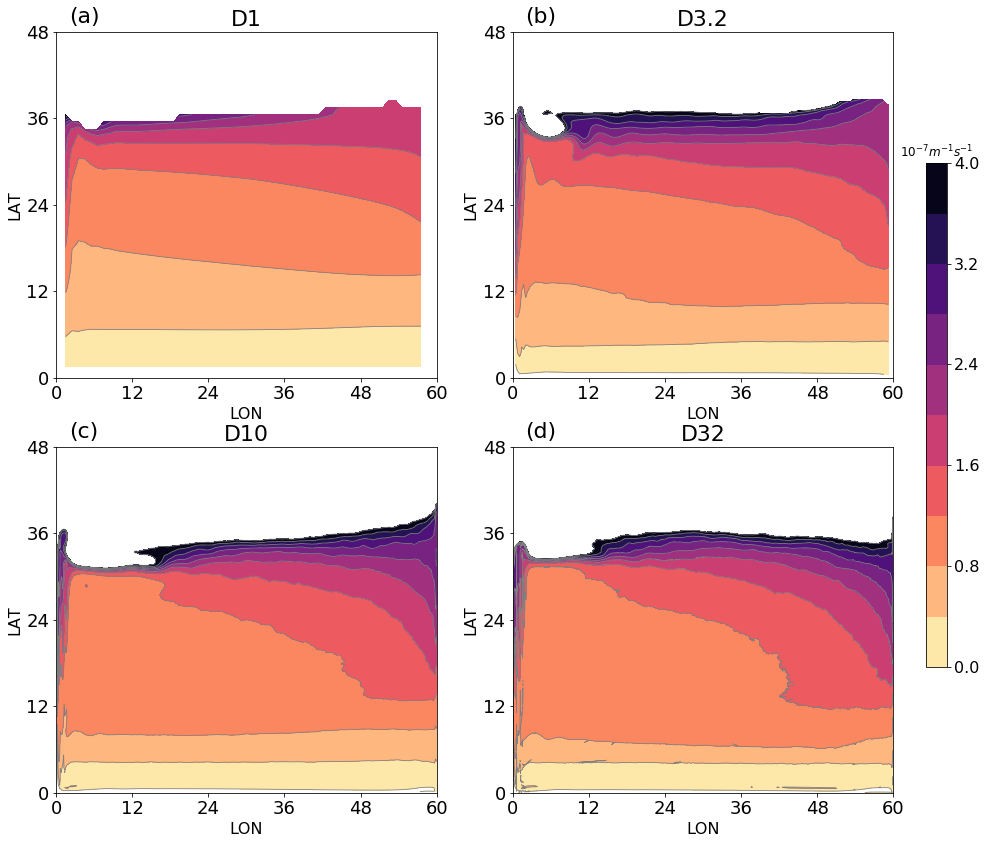

In [10]:
fig = plt.figure(figsize=(15, 14))

lev1 = np.arange(0,4.1,0.4)
lev2 = np.arange(0,4.1,0.4)
plt.subplot(221)
plt.contourf(lon1, lat1, pv1, lev1, cmap='magma_r')
plt.contour(lon1, lat1,pv1, lev2, colors='gray', linewidths=0.8)
plt.ylabel('LAT')
plt.xlabel('LON')
plt.title('D1', size=22)
plt.text(2, 49.2, '(a)', size=22)
x_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(x_ticks)
plt.xlim(0, 60)
plt.ylim(0, 48)
#plt.plot([0, 60], [10, 10], 'k--')
#plt.plot([0, 60], [36, 36], 'k--')

plt.subplot(222)
plt.contourf(lon2, lat2, pv2, lev1, cmap='magma_r')
plt.contour(lon2, lat2, pv2, lev2, colors='gray', linewidths=0.8)
plt.xlabel('LON')
plt.ylabel('LAT')

x_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(x_ticks)
plt.ylim(0, 48)
plt.title('D3.2', size=22)
plt.xlabel('LON')
plt.text(2, 49.2, '(b)', size=22)

plt.subplot(223)
h1 = plt.contourf(lon3, lat3, pv3, lev1, cmap='magma_r')
plt.contour(lon3, lat3, pv3, lev2, colors='gray', linewidths=0.8)
plt.ylabel('LAT')
plt.xlabel('LON')

x_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(x_ticks)
plt.ylim(0, 48)
plt.title('D10', size=22)
plt.text(2, 49.2, '(c)', size=22)

plt.subplot(224)
h1 = plt.contourf(lon4, lat4, pv4, lev1, cmap='magma_r')
plt.contour(lon4, lat4, pv4, lev2, colors='gray', linewidths=0.8)
plt.ylabel('LAT')
plt.xlabel('LON')

x_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)
plt.yticks(x_ticks)
plt.ylim(0, 48)
plt.title('D32', size=22)
plt.text(2, 49.2, '(d)', size=22)

cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
hc = fig.colorbar(h1, cax=cbar_ax)
hc.ax.tick_params(labelsize=16)
hc.ax.set_title(r'$10^{-7} m^{-1}s^{-1}$', size=12)

plt.savefig('./pics/Figure_07.png', dpi=300, bbox_inches='tight')

/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/WORK/sio_goc03/anaconda3/envs/eddypy/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


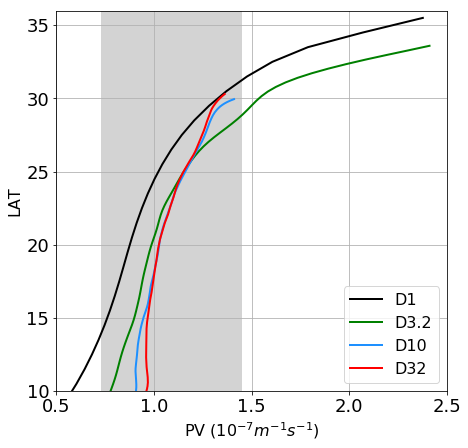

In [11]:
fig = plt.figure(figsize=(7, 7))

datatmp1 = np.nanmean(pv1[:, 9:30], 1)
data_pv1 = smooth_1d(datatmp1)

datatmp2 = np.nanmean(pv2[:, 32:96], 1)
data_pv2 = smooth_1d(datatmp2)

datatmp3 = np.nanmean(pv3[:, 100:300], 1)
data_pv3 = smooth_1d(datatmp3)

datatmp4 = np.nanmean(pv4[:, 320:960], 1)
data_pv4 = smooth_1d(datatmp4)

xx = np.arange(0.73, 1.46, 0.04)
yy = np.arange(10, 37, 2)
arraypv = np.zeros((14, 19))
arraypv[:, :] = 0.2
plt.contourf(xx, yy, arraypv, colors='lightgray')

plt.plot(data_pv1[:36], lat1[:36], linewidth= 2, color='k', label='D1')
plt.plot(data_pv2[:108], lat2[:108], linewidth= 2, color='g',label='D3.2')
plt.plot(data_pv3[:300], lat3[:300], linewidth= 2, color='dodgerblue',label='D10')
plt.plot(data_pv4[:970], lat4[:970], linewidth= 2, color='red',label='D32')
#plt.plot([1.2, 1.2], [10, 36], linewidth= 2, color='g',label='Analytical', linestyle='--')

#plt.plot([0.5, 3], [35, 35], linestyle='--', color='k')
#plt.plot([0.5, 3], [30, 30], linestyle='--', color='r')

plt.ylabel('LAT')
plt.xlabel(r'PV ($10^{-7} m^{-1}s^{-1}$)')

plt.grid()
plt.ylim(10, 36)
plt.xlim(0.5, 2.5)
plt.xticks(np.arange(0.5, 2.51, 0.5))
plt.legend(loc=4)

plt.savefig('./pics/Figure_08.png', dpi=200, bbox_inches='tight')

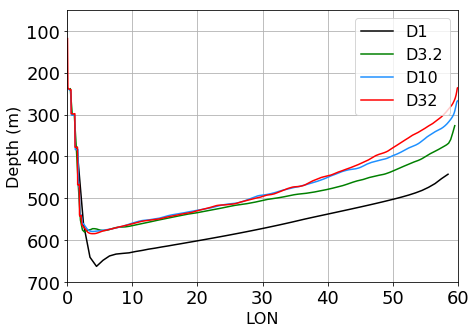

In [38]:
fig = plt.figure(figsize=(7, 5))
plt.plot(ds1.XC, dep_iso1[24, :], color='k', label='D1')
plt.plot(ds2.XC, dep_iso2[76, :], color='g', label='D3.2')
plt.plot(ds3.XC, dep_iso3[240, :], color='dodgerblue', label='D10')
plt.plot(ds4.XC, dep_iso4[768, :], color='r', label='D32')

plt.grid()
plt.legend(loc=1)
plt.xlabel('LON')
plt.ylabel('Depth (m)')

plt.xlim(0, 60)
plt.ylim(50, 700)
plt.gca().invert_yaxis()